# Instancia de librarias

In [3]:
import pandas as pd
import numpy as np
# import datetime as dt
from datetime import datetime

# Series de tiempo
import scipy.stats as stats
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose # graficas de estacionalidad y tendencia
from statsmodels.tsa.stattools import adfuller # prueba 
from statsmodels.tsa.statespace.sarimax import SARIMAX #SARIMAX
import pmdarima as pm # autoarima

from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler  # Estandarización de los datos
from sklearn.model_selection import cross_val_score

# import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

# Formato de visualización por centenas
pd.options.display.float_format = '{:,.2f}'.format

# Graficas
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns;sns.set_theme(color_codes=True)

# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

print("Setup complete")

Setup complete


In [8]:
# !pip install prophet --user


# Importación de datos

In [4]:
path = r'E:\\skillsForIndustry/project_wallmart/data/Walmart_Store_sales.csv'
wall_data = pd.read_csv(path, header=0, encoding='utf-8')

In [5]:
wall_data['Date'] = pd.to_datetime(wall_data['Date'],format="%d-%m-%Y",dayfirst=True)
# wall_data.info()
wall_data['year'] = pd.DatetimeIndex(wall_data['Date']).year
wall_data['month'] = pd.DatetimeIndex(wall_data['Date']).month
wall_data['day'] = pd.DatetimeIndex(wall_data['Date']).day
wall_data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day
0,1,2010-02-05,"1,643,690.90",0,42.31,2.57,211.10,8.11,2010,2,5
1,1,2010-02-12,"1,641,957.44",1,38.51,2.55,211.24,8.11,2010,2,12
2,1,2010-02-19,"1,611,968.17",0,39.93,2.51,211.29,8.11,2010,2,19
3,1,2010-02-26,"1,409,727.59",0,46.63,2.56,211.32,8.11,2010,2,26
4,1,2010-03-05,"1,554,806.68",0,46.50,2.62,211.35,8.11,2010,3,5


#### Performance

In [6]:
def performance(a,b):
    print('Mean Absolute Error: ',metrics.mean_absolute_error(a,b))
    print('Mean Square Error: ',metrics.mean_squared_error(a,b))
    print('Root Mean Square Error: ',np.sqrt(metrics.mean_squared_error(a,b)))
    print('Mean Absolute Percentage Error: ', metrics.mean_absolute_percentage_error(a,b))
    
    plt.figure(figsize=(10,8),dpi=60)
    sns.regplot(b,a);
    
def cross_validation(model,a,b):
    cv = cross_val_score(model,a,b,cv=10,scoring='r2')
    print(f'Cross validation: {cv.mean()*100}%')

#### ADF

In [7]:
def adf(series,column_name):
    print(f'Resultados ADF: ,{column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used', 'Observation number'])
    for key, value in dftest[4].items():
        dfoutput['Critical Values (%s)'%key] = value
    print(dfoutput)
    if ((dftest[1] > 0.00) & (dftest[1] <= 0.05)):
        print('Los datos son estacionarios')
    else:
        print('Los datos no son estacionarios')

## Series de Tiempo

## Mensual

#### Tienda 20

In [13]:
wall_data_store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2,8,9,10]]
# wall_data_store_20 
wall_data_store_20_promedio_mensual= wall_data_store_20.groupby(['year','month'])[['Weekly_Sales']].mean().reset_index()
wall_data_store_20_promedio_mensual['year_str']=wall_data_store_20_promedio_mensual.year.apply(str)
wall_data_store_20_promedio_mensual['month_str']=wall_data_store_20_promedio_mensual.month.apply(str)
# wall_data_store_20_promedio_mensual.info()
wall_data_store_20_promedio_mensual['year_month'] = wall_data_store_20_promedio_mensual[['year_str','month_str']].apply('-'.join,axis=1)
# wall_data_store_20_promedio_mensual.head()
wall_data_store_20_promedio_mensual['Date']=pd.to_datetime(wall_data_store_20_promedio_mensual['year_month'],format="%Y-%m",yearfirst=True)
wall_data_store_20_promedio_mensual = wall_data_store_20_promedio_mensual.iloc[:,[6,2]]
wall_data_store_20_promedio_mensual.head()

,Date,Weekly_Sales
0,2010-02-01,"2,142,561.77"
1,2010-03-01,"1,994,194.99"
2,2010-04-01,"2,039,378.34"
3,2010-05-01,"2,032,533.96"
4,2010-06-01,"2,092,287.16"


<AxesSubplot:>

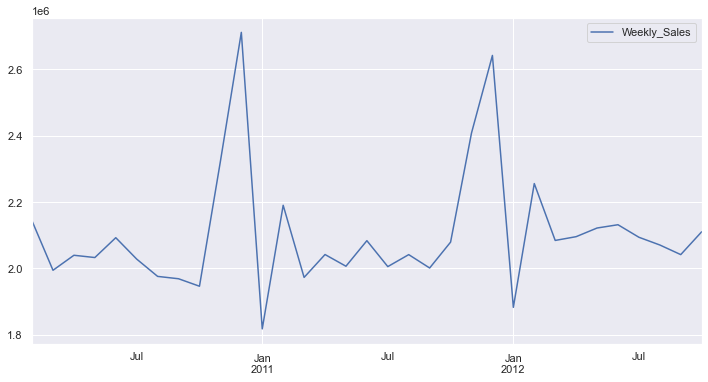

In [14]:
wall_data_store_20_promedio_mensual.set_index('Date',inplace=True)
wall_data_store_20_promedio_mensual = wall_data_store_20_promedio_mensual.rename_axis(index=None, columns = None)
plt.rcParams["figure.figsize"] = (12,6)
wall_data_store_20_promedio_mensual.plot()

In [15]:
adf(wall_data_store_20_promedio_mensual.Weekly_Sales,'Weekly_Sales')

Resultados ADF: ,Weekly_Sales
Test Statistic          -5.57
p-value                  0.00
No Lags Used             0.00
Observation number      32.00
Critical Values (1%)    -3.65
Critical Values (5%)    -2.96
Critical Values (10%)   -2.62
dtype: float64
Los datos son estacionarios


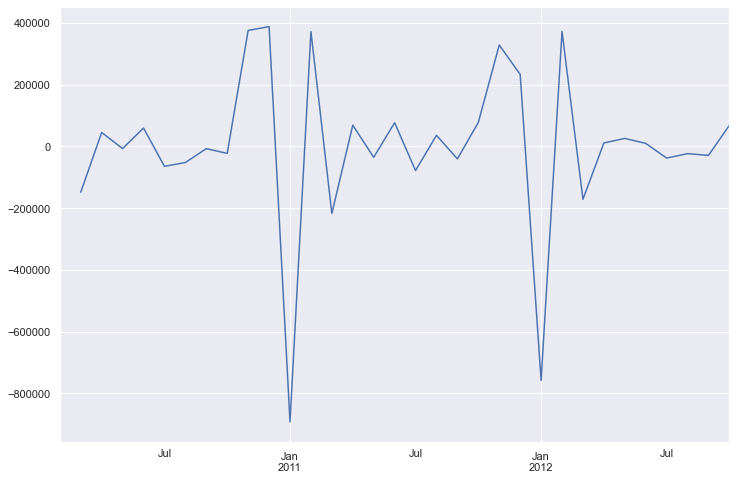

In [16]:
prev_store_20_value = wall_data_store_20_promedio_mensual.Weekly_Sales.shift()
differenced_store_20 = wall_data_store_20_promedio_mensual.Weekly_Sales - prev_store_20_value
plt.rcParams["figure.figsize"] = (12,8)
differenced_store_20.plot();

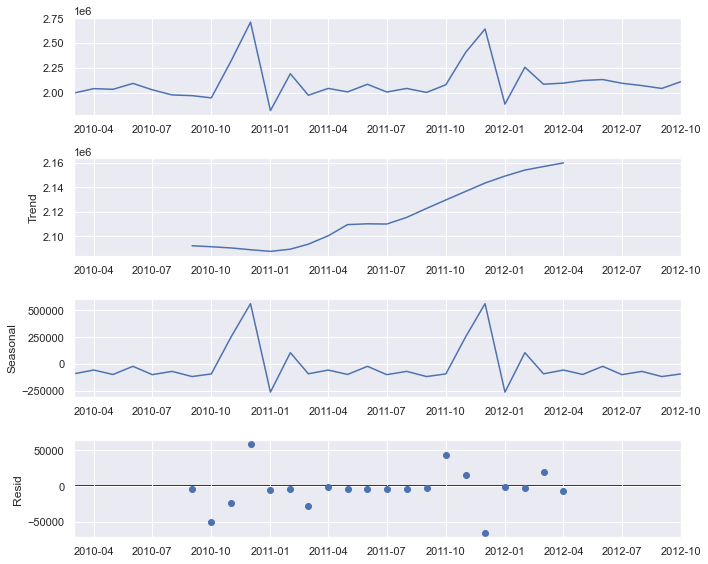

In [17]:
differenced_store_20_dif = seasonal_decompose(wall_data_store_20_promedio_mensual.iloc[1:],model='additive',period = 12)
plt.rcParams["figure.figsize"] = (10,8)
differenced_store_20_dif.plot();

### ARIMA

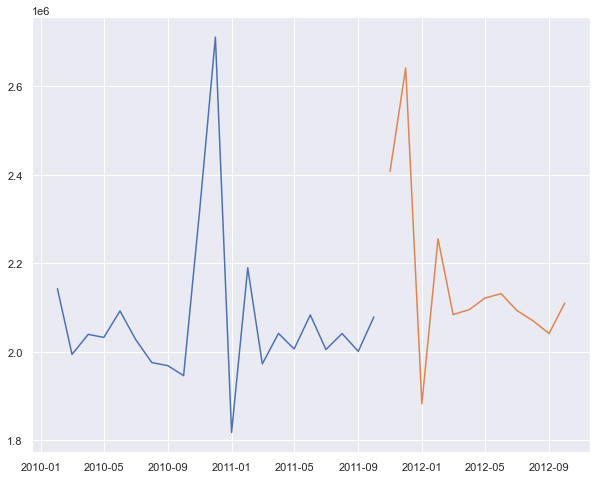

In [18]:
train = wall_data_store_20_promedio_mensual.Weekly_Sales[:len(wall_data_store_20_promedio_mensual.Weekly_Sales)-12]  # primero datos
test = wall_data_store_20_promedio_mensual.Weekly_Sales[len(wall_data_store_20_promedio_mensual.Weekly_Sales)-12:]   # últimos datos
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(train)
plt.plot(test)

In [19]:
# Nunca se debe utilizar toda la información de un dataset, debe ser el dataset de train 
# para el entrenamiento de los modelo.
# El test nunca filtra inforamción al train.
arima_model = pm.auto_arima(train, start_p=0,d=0,start_q=0,max_p=5,max_d=5,max_q=5,
                            start_P=0,D=1,start_Q=0,max_P=5,max_D=5,max_Q=5,m=12,
                            seasonal=True,error_Action='warn',trace=True,test='adf',
                            supress_warnings = True, stepwise=True, random_state=20,
                            n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=224.291, Time=0.25 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=228.002, Time=0.09 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=228.362, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=224.829, Time=0.02 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=226.290, Time=0.02 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=226.290, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=226.011, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=226.444, Time=0.01 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=225.971, Time=0.09 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.055 seconds


#### SARIMAX

In [20]:
# D:parametro parte estacional, d:parametro parte no estacional
# from statsmodels.tsa.statespace.sarimax import SARIMAX
arima_model = SARIMAX(train,order=(0,0,0),seasonal_order = (0,1,0,12))     #AIC 380.096; D=1;d=0
arima_result = arima_model.fit() 
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:             Weekly_Sales   No. Observations:                   21
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -111.415
Date:                  Sun, 04 Dec 2022   AIC                            224.829
Time:                          22:37:20   BIC                            225.026
Sample:                      02-01-2010   HQIC                           224.403
                           - 10-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.978e+09   4.81e+08      4.117      0.000    1.04e+09    2.92e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.61   Prob(JB):                         0.48
Heteroskedasticity (H):               8.48   Skew:                             0.99
Prob(H) (two-sided):                  0.11   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
arima_result.model_orders
# r2. si no hay una cte (ar,phi_0) en el modelo. este es negativo.

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 0,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 0,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [22]:
arima_pred = arima_result.predict(start=len(train),end=len(wall_data_store_20_promedio_mensual)-1,type='levels').rename('ARIMA Predictions')
arima_pred
# el autoarima no tiene una cte 

2011-11-01   2,322,193.72
2011-12-01   2,710,758.33
2012-01-01   1,817,672.07
2012-02-01   2,189,938.99
2012-03-01   1,972,684.31
2012-04-01   2,041,621.16
2012-05-01   2,006,359.05
2012-06-01   2,083,331.58
2012-07-01   2,005,234.94
2012-08-01   2,041,298.79
2012-09-01   2,001,049.19
2012-10-01   2,078,938.47
Freq: MS, Name: ARIMA Predictions, dtype: float64

<AxesSubplot:>

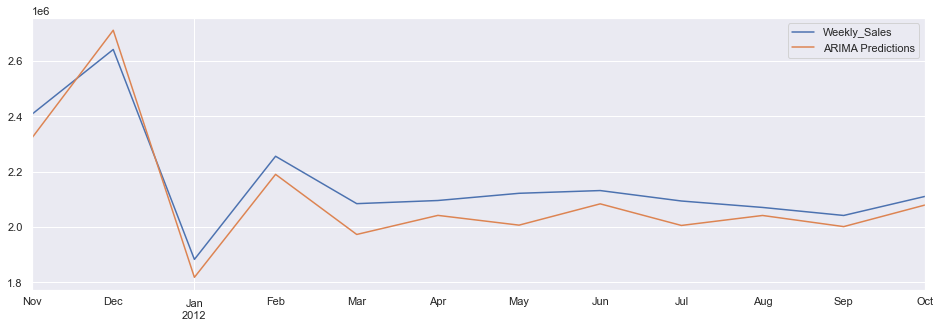

In [23]:
test.plot(figsize=(16,5),legend=True)
arima_pred.plot(legend=True)

Accuracy test(R2):  85.08172077109136
Mean Absolute Error:  66852.11704166663
Mean Square Error:  5224463219.885597
Root Mean Square Error:  72280.44839294784
Mean Absolute Percentage Error:  0.030986461666270827


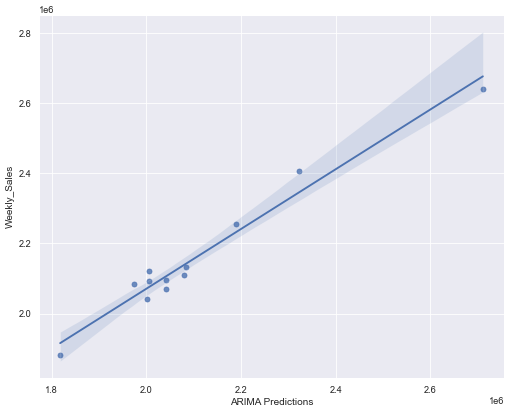

In [24]:
print('Accuracy test(R2): ', metrics.r2_score(test,arima_pred)*100)
performance(test,arima_pred)

## Prophet

In [222]:
# !pip3 install more-itertools --user
import itertools
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
plt.rcParams['figure.figsize'] = (20,5)

In [223]:
store_20 = wall_data[wall_data['Store']==20].iloc[:,[1,2,8,9,10]]

store_20['Date'] = pd.PeriodIndex(store_20.Date,freq='M')
store_20 = store_20.groupby(['Date'])[['Weekly_Sales','Date']].mean().reset_index()

store_20 = store_20.rename(columns={'Date':'ds','Weekly_Sales':'y'})
# store_20.columns=['ds','y']

# store_20.head()
# store_20.info()
store_20['ds'] = store_20.ds.astype(str)
store_20['ds'] = pd.to_datetime(store_20['ds'])
store_20.head()

,ds,y
0,2010-02-01,"2,142,561.77"
1,2010-03-01,"1,994,194.99"
2,2010-04-01,"2,039,378.34"
3,2010-05-01,"2,032,533.96"
4,2010-06-01,"2,092,287.16"


In [214]:
# train = store_20[:len(store_20)-6]  # primero datos
# test = store_20[len(store_20)-6:]   # últimos datos
# # plt.rcParams["figure.figsize"] = (10,8)
# plt.plot(train.y)
# plt.plot(test.y)

In [213]:
# forecast = pd.DataFrame({'ds':pd.to_datetime([x for x in range(2013,2025)],
#                                             format='%Y'), 'y':np.nan})
# forecast.tail()

In [224]:
m = Prophet(interval_width= 0.95)
training_run = m.fit(store_20)

21:58:30 - cmdstanpy - INFO - Chain [1] start processing
21:58:30 - cmdstanpy - INFO - Chain [1] done processing


In [261]:
# Mensuasl
future = m.make_future_dataframe(periods=200, freq='M')

# Diario
# future = m.make_future_dataframe(periods=390, freq='D')

In [262]:
future.tail()

,ds
228,2029-01-31
229,2029-02-28
230,2029-03-31
231,2029-04-30
232,2029-05-31


In [263]:
forecast = m.predict(future)

In [264]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
228,2029-01-31,"3,429,178.11","1,870,753.15","5,281,330.80","1,737,753.23","5,153,576.56","132,474.56","132,474.56","132,474.56","132,474.56","132,474.56","132,474.56",0.00,0.00,0.00,"3,561,652.68"
229,2029-02-28,"3,434,784.06","1,535,610.73","4,983,190.94","1,727,833.91","5,175,411.90","-210,100.77","-210,100.77","-210,100.77","-210,100.77","-210,100.77","-210,100.77",0.00,0.00,0.00,"3,224,683.29"
230,2029-03-31,"3,440,990.64","1,624,892.02","5,099,183.80","1,723,639.59","5,198,724.22","-102,551.30","-102,551.30","-102,551.30","-102,551.30","-102,551.30","-102,551.30",0.00,0.00,0.00,"3,338,439.34"
231,2029-04-30,"3,446,997.01","1,543,431.94","5,048,421.36","1,716,032.85","5,222,717.33","-172,762.55","-172,762.55","-172,762.55","-172,762.55","-172,762.55","-172,762.55",0.00,0.00,0.00,"3,274,234.46"
232,2029-05-31,"3,453,203.59","1,663,443.93","5,188,038.78","1,708,883.24","5,247,502.92","-48,306.28","-48,306.28","-48,306.28","-48,306.28","-48,306.28","-48,306.28",0.00,0.00,0.00,"3,404,897.31"


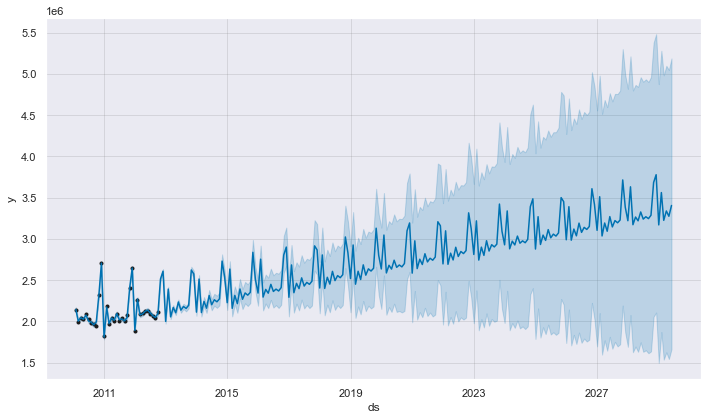

In [265]:
plot = m.plot(forecast)

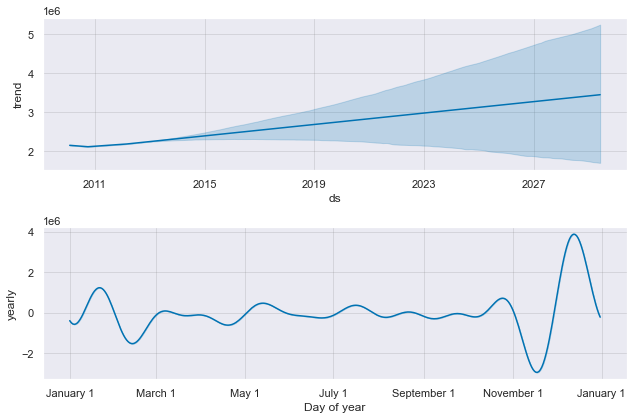

In [266]:
plot2 = m.plot_components(forecast)

## Multiple tiendas

In [388]:
# stores = wall_data[(wall_data['Store']==20)|(wall_data['Store']==13)|(wall_data['Store']==5)]
stores = wall_data
stores = stores.iloc[:,[1,0,2]]
stores['Date'] = pd.PeriodIndex(stores.Date, freq='M')
stores = stores.groupby(['Date','Store']).mean().reset_index()
stores.columns = ['ds','store','y']
stores['ds'] = stores.ds.astype(str)
stores['store'] = stores.store.astype(str)
stores['ds'] = pd.to_datetime(stores['ds'])
stores.tail()

,ds,store,y
1480,2012-10-01,41,"1,363,111.44"
1481,2012-10-01,42,"565,426.37"
1482,2012-10-01,43,"618,376.85"
1483,2012-10-01,44,"340,005.10"
1484,2012-10-01,45,"736,581.60"


In [391]:
num_store = stores.store.unique()
num_store = num_store[[4,13,19]]
num_store

array(['5', '14', '20'], dtype=object)

In [392]:
for store in num_store:
    print(store)

5
14
20


In [454]:
for store in num_store:
    frame = stores[stores['store']==store]
    print(frame.head())

            ds store          y
4   2010-02-01     5 300,682.00
49  2010-03-01     5 285,284.67
94  2010-04-01     5 310,764.55
139 2010-05-01     5 310,456.24
184 2010-06-01     5 310,880.17
            ds store            y
13  2010-02-01    14 2,156,959.28
58  2010-03-01    14 2,127,548.85
103 2010-04-01    14 2,219,340.09
148 2010-05-01    14 2,208,806.73
193 2010-06-01    14 2,276,999.25
            ds store            y
19  2010-02-01    20 2,142,561.77
64  2010-03-01    20 1,994,194.99
109 2010-04-01    20 2,039,378.34
154 2010-05-01    20 2,032,533.96
199 2010-06-01    20 2,092,287.16


In [455]:
fit_models = {}
for store in num_store:
    frame = stores[stores['store']==store]
    frame.drop('store',axis=1, inplace=True)
    
    m = Prophet(interval_width=0.95)
    model = m.fit(frame)
    fit_models[store] = m

00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:03 - cmdstanpy - INFO - Chain [1] done processing
00:25:03 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing
00:25:04 - cmdstanpy - INFO - Chain [1] start processing
00:25:04 - cmdstanpy - INFO - Chain [1] done processing


In [441]:
len(frame)

33

In [442]:
fit_models

{'5': <prophet.forecaster.Prophet at 0x12980923fd0>,
 '14': <prophet.forecaster.Prophet at 0x129808ea4c0>,
 '20': <prophet.forecaster.Prophet at 0x129ff58f5e0>}

In [473]:
futuro = fit_models['5'].make_future_dataframe(periods=80, freq='M')
forecast = fit_models['5'].predict(futuro)


In [474]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-02-01,"306,528.43","291,837.84","310,567.83","306,528.43","306,528.43","-5,477.16","-5,477.16","-5,477.16","-5,477.16","-5,477.16","-5,477.16",0.00,0.00,0.00,"301,051.27"
1,2010-03-01,"307,240.02","287,406.51","305,951.59","307,240.02","307,240.02","-10,549.93","-10,549.93","-10,549.93","-10,549.93","-10,549.93","-10,549.93",0.00,0.00,0.00,"296,690.09"
2,2010-04-01,"308,027.85","301,590.62","319,606.05","308,027.85","308,027.85","2,752.99","2,752.99","2,752.99","2,752.99","2,752.99","2,752.99",0.00,0.00,0.00,"310,780.84"
3,2010-05-01,"308,790.27","294,518.91","312,426.61","308,790.27","308,790.27","-4,896.51","-4,896.51","-4,896.51","-4,896.51","-4,896.51","-4,896.51",0.00,0.00,0.00,"303,893.76"
4,2010-06-01,"309,575.04","295,590.82","314,944.03","309,575.04","309,575.04","-4,512.32","-4,512.32","-4,512.32","-4,512.32","-4,512.32","-4,512.32",0.00,0.00,0.00,"305,062.72"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2019-01-31,"500,017.51","481,026.80","572,910.33","455,534.36","545,775.82","27,482.17","27,482.17","27,482.17","27,482.17","27,482.17","27,482.17",0.00,0.00,0.00,"527,499.68"
109,2019-02-28,"501,817.92","427,645.24","521,943.25","456,137.48","548,805.55","-27,889.15","-27,889.15","-27,889.15","-27,889.15","-27,889.15","-27,889.15",0.00,0.00,0.00,"473,928.77"
110,2019-03-31,"503,811.23","441,629.44","538,093.49","456,932.03","551,897.76","-14,121.67","-14,121.67","-14,121.67","-14,121.67","-14,121.67","-14,121.67",0.00,0.00,0.00,"489,689.56"
111,2019-04-30,"505,740.24","438,283.77","538,311.95","457,973.66","554,679.17","-16,906.78","-16,906.78","-16,906.78","-16,906.78","-16,906.78","-16,906.78",0.00,0.00,0.00,"488,833.46"


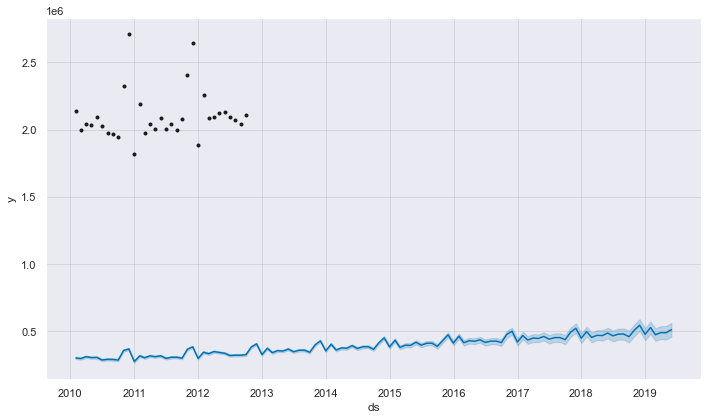

In [475]:
plot = m.plot(forecast)

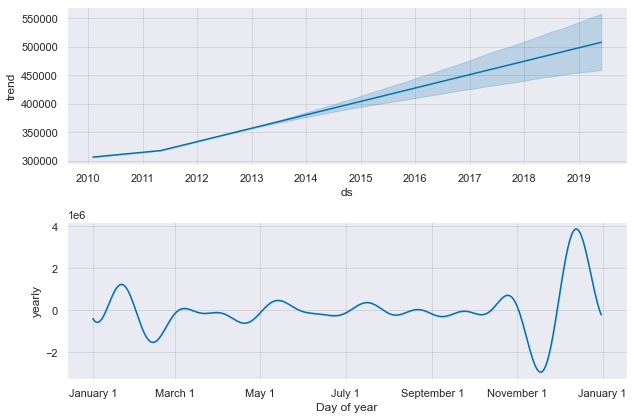

In [476]:
plot2 = m.plot_components(forecast)

In [433]:
# wall_data['Store'].unique()
# stores = [1,5,13,20]
#14 5 13 ,27
    

# [x for x in wall_data[['Store']] if x in stores]
# x=2

# wall_data[wall_data['Store']== x]
# [x for x in stores]
# wall_data['Store'].apply(lambda x: wall_data[wall_data['Store']] if x in stores )